In [171]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.weightstats import ttest_ind
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [172]:
dpw_beacon_df = pd.read_csv("data/NO2_DPW_beacon.csv")
dpw_df = pd.read_csv("data/NO2_DPW_filtered.csv")

In [173]:
dpw_beacon_df.head()

,local_timestamp,epoch,datetime,node_file_id,no2_aux,o3_wrk_aux,no_wrk_aux,temp,rh,node_id
0,2024-12-16 00:00:00,1.734336e+09,2024-12-16 08:00:00,5293194,0.32365,0.00194,0.02246,NaN,NaN,276
1,2024-12-16 00:01:00,1.734336e+09,2024-12-16 08:01:00,5293194,0.32384,0.00265,0.02224,6.49000,44.48500,276
2,2024-12-16 00:02:00,1.734336e+09,2024-12-16 08:02:00,5293194,NaN,NaN,NaN,NaN,NaN,276
3,2024-12-16 00:03:00,1.734336e+09,2024-12-16 08:03:00,5293194,0.32328,0.00247,0.02145,6.49917,44.48120,276
4,2024-12-16 00:04:00,1.734336e+09,2024-12-16 08:04:00,5293194,0.32330,0.00273,0.02146,6.49615,44.38477,276


In [174]:
dpw_df["datetime_utc"] = pd.to_datetime(dpw_df["datetime_utc"])
dpw_beacon_df["datetime"] = pd.to_datetime(dpw_beacon_df["datetime"])

valid_times = set(dpw_df["datetime_utc"])

dpw_beacon_df_filtered = dpw_beacon_df[dpw_beacon_df["datetime"].isin(valid_times)].copy()
dpw_beacon_df_filtered.head()


,local_timestamp,epoch,datetime,node_file_id,no2_aux,o3_wrk_aux,no_wrk_aux,temp,rh,node_id
1434,2024-12-17 00:00:00,1.734422e+09,2024-12-17 08:00:00,5298548,0.32314,0.01035,0.02204,15.69000,68.77043,276
1435,2024-12-17 00:01:00,1.734422e+09,2024-12-17 08:01:00,5298548,0.32333,0.01058,0.02333,15.69000,68.78125,276
1436,2024-12-17 00:02:00,1.734423e+09,2024-12-17 08:02:00,5298548,0.32316,0.01042,0.02210,15.69364,68.77521,276
1437,2024-12-17 00:03:00,1.734423e+09,2024-12-17 08:03:00,5298548,0.32315,0.01083,0.02179,15.69500,68.77376,276
1438,2024-12-17 00:04:00,1.734423e+09,2024-12-17 08:04:00,5298548,0.32358,0.01042,0.02261,15.69417,68.77197,276


In [175]:
training_df = pd.merge(
    dpw_beacon_df_filtered,
    dpw_df[["datetime_utc", "no2"]],
    left_on="datetime",
    right_on="datetime_utc"
)
training_df.rename(columns={"no2": "true_no2"}, inplace=True)
training_df.head()
# training_df.to_csv("test.csv")

,local_timestamp,epoch,datetime,node_file_id,no2_aux,o3_wrk_aux,no_wrk_aux,temp,rh,node_id,datetime_utc,true_no2
0,2024-12-17 00:00:00,1.734422e+09,2024-12-17 08:00:00,5298548,0.32314,0.01035,0.02204,15.69000,68.77043,276,2024-12-17 08:00:00,9.306
1,2024-12-17 00:01:00,1.734422e+09,2024-12-17 08:01:00,5298548,0.32333,0.01058,0.02333,15.69000,68.78125,276,2024-12-17 08:01:00,9.281
2,2024-12-17 00:02:00,1.734423e+09,2024-12-17 08:02:00,5298548,0.32316,0.01042,0.02210,15.69364,68.77521,276,2024-12-17 08:02:00,9.346
3,2024-12-17 00:03:00,1.734423e+09,2024-12-17 08:03:00,5298548,0.32315,0.01083,0.02179,15.69500,68.77376,276,2024-12-17 08:03:00,9.322
4,2024-12-17 00:04:00,1.734423e+09,2024-12-17 08:04:00,5298548,0.32358,0.01042,0.02261,15.69417,68.77197,276,2024-12-17 08:04:00,9.284


In [176]:
def plot_side_by_side_boxes(data1, data2, labels=("Data 1", "Data 2"), title="Side-by-Side Box Plot", show_r2=False):
    fig, ax = plt.subplots(figsize=(7, 6))

    ax.boxplot([data1, data2], labels=labels, patch_artist=True,
               boxprops=dict(facecolor="lightblue", color="navy"),
               medianprops=dict(color="darkred"),
               whiskerprops=dict(color="navy"),
               capprops=dict(color="navy"),
               flierprops=dict(marker="o", color="gray", alpha=0.5))

    if show_r2:
        r2 = r2_score(data1, data2)
        title += f" (R² = {r2:.3f})"

    ax.set_title(title)
    ax.set_ylabel("Value")
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [177]:
def plot_overlaid_histograms(data1, data2, labels=("Data 1", "Data 2"),
                              title="Overlaid Histograms", show_r2=False,
                              bins=30, alpha=0.6, density=False):
    
    fig, ax = plt.subplots(figsize=(8, 6))

    all_data = np.concatenate([data1, data2])
    bin_edges = np.linspace(all_data.min(), all_data.max(), bins + 1)

    ax.hist(data1, bins=bin_edges, alpha=alpha, label=labels[0], color="steelblue", density=density, edgecolor="black")
    ax.hist(data2, bins=bin_edges, alpha=alpha, label=labels[1], color="darkorange", density=density, edgecolor="black")

    if show_r2:
        r2 = r2_score(data1, data2)
        title += f" (R² = {r2:.3f})"

    ax.set_title(title)
    ax.set_xlabel("Value")
    ax.set_ylabel("Density" if density else "Frequency")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [178]:
feature_cols = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh"]

#will probably we worth interpolating some data in the future
training_df_clean = training_df.dropna(subset=["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "true_no2"])

X = training_df_clean[feature_cols]
y = training_df_clean["true_no2"]

model = LinearRegression()
model.fit(X, y)


coefficients = model.coef_
intercept = model.intercept_

for feature, coef in zip(feature_cols, coefficients):
    print(f"{feature}: {coef:.6f}")
print(f"Intercept (bias): {intercept:.6f}")


no2_aux: -22.128890
o3_wrk_aux: 149.139643
no_wrk_aux: 341.627119
temp: -0.605865
rh: 0.047026
Intercept (bias): 19.941327


0        9.306
1        9.281
2        9.346
3        9.322
4        9.284
         ...  
17262    3.724
17263    3.696
17264    3.655
17265    4.898
17266    6.867
Name: true_no2, Length: 16526, dtype: float64
[15.59165013 16.06295557 15.6201644  ...  6.23951725  6.84230881
  6.22907238]


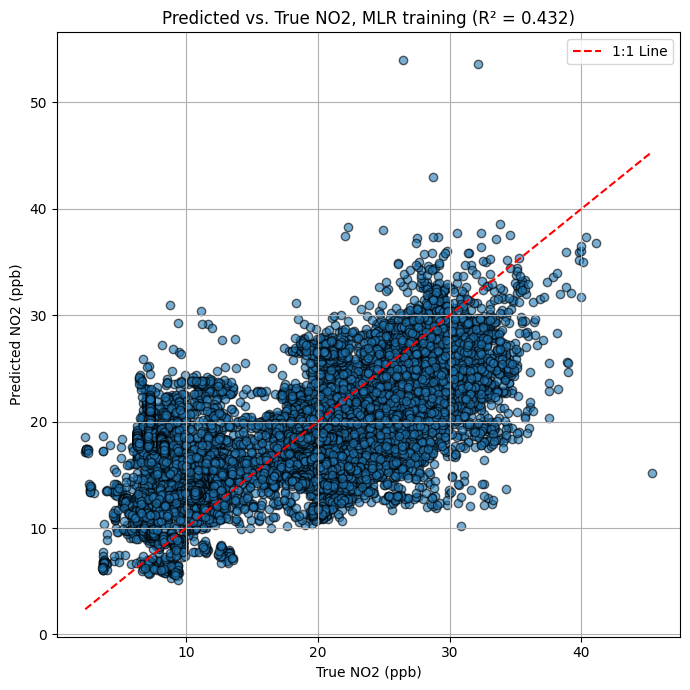

In [179]:
y_true = training_df_clean["true_no2"]
y_pred = model.predict(training_df_clean[feature_cols])

print(y_true)
print(y_pred)

r2 = r2_score(y_true, y_pred)

plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="1:1 Line")
plt.xlabel("True NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f"Predicted vs. True NO2, MLR training (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/cv/16s476bd69z2kjqnmm06ls5c0000gn/T/ipykernel_45246/407025799.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data1, data2], labels=labels, patch_artist=True,


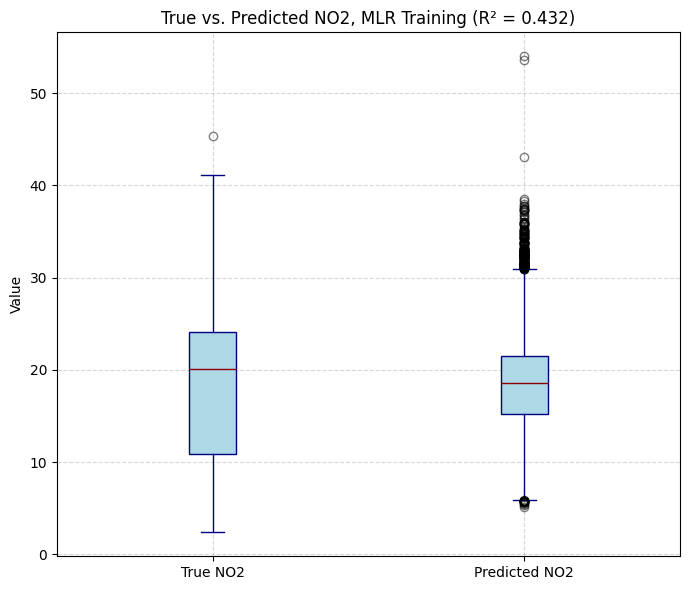

In [180]:
plot_side_by_side_boxes(y_true, y_pred,
                        labels=("True NO2", "Predicted NO2"),
                        title="True vs. Predicted NO2, MLR Training",
                        show_r2=True)

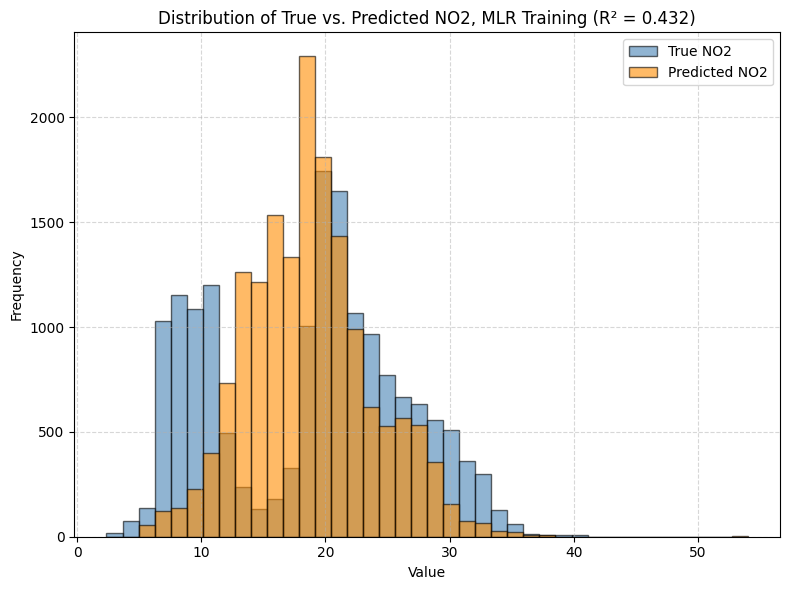

In [181]:
plot_overlaid_histograms(y_true, y_pred,
                         labels=("True NO2", "Predicted NO2"),
                         title="Distribution of True vs. Predicted NO2, MLR Training",
                         show_r2=True,
                         bins=40,
                         density=False)

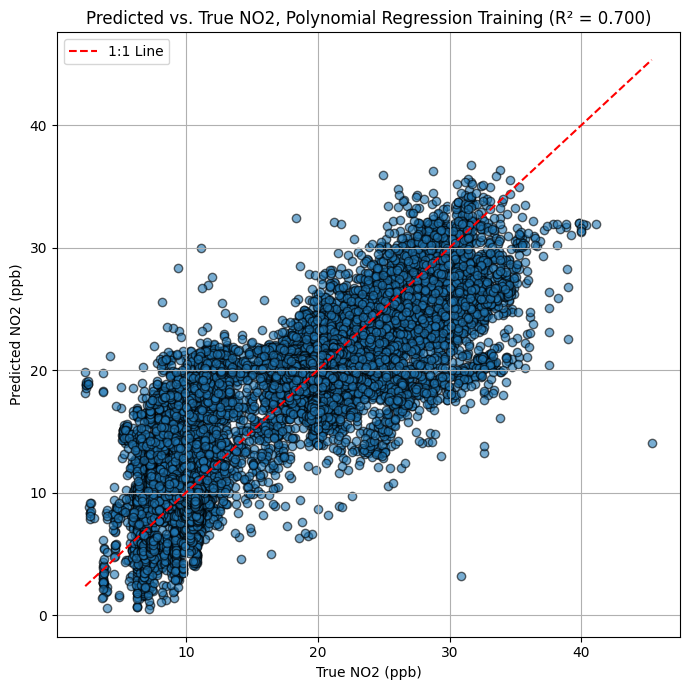

In [182]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
feature_cols = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh"]

#will probably we worth interpolating some data in the future
training_df_clean = training_df.dropna(subset=["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "true_no2"])

X = training_df_clean[feature_cols]
y = training_df_clean["true_no2"]

poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X, y)
y_pred = poly_model.predict(X)

y_true = training_df_clean["true_no2"]

r2 = r2_score(y_true, y_pred)

plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="1:1 Line")
plt.xlabel("True NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f"Predicted vs. True NO2, Polynomial Regression Training (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/var/folders/cv/16s476bd69z2kjqnmm06ls5c0000gn/T/ipykernel_45246/407025799.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data1, data2], labels=labels, patch_artist=True,


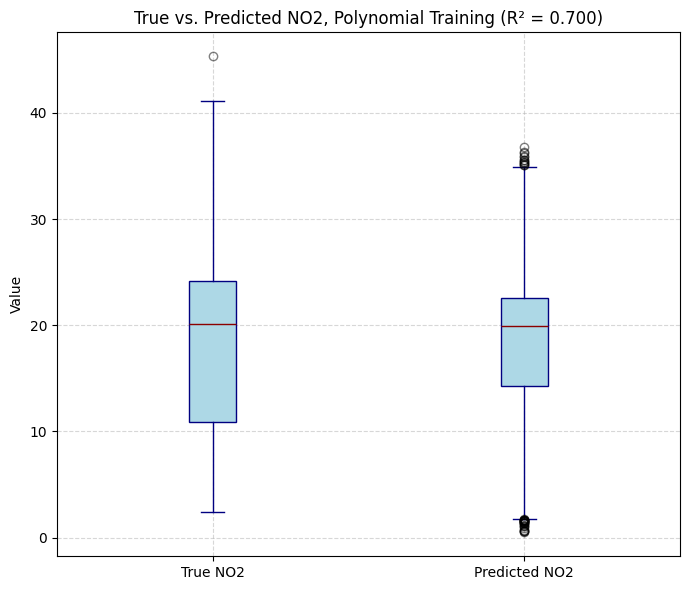

In [183]:
plot_side_by_side_boxes(y_true, y_pred,
                        labels=("True NO2", "Predicted NO2"),
                        title="True vs. Predicted NO2, Polynomial Training",
                        show_r2=True)

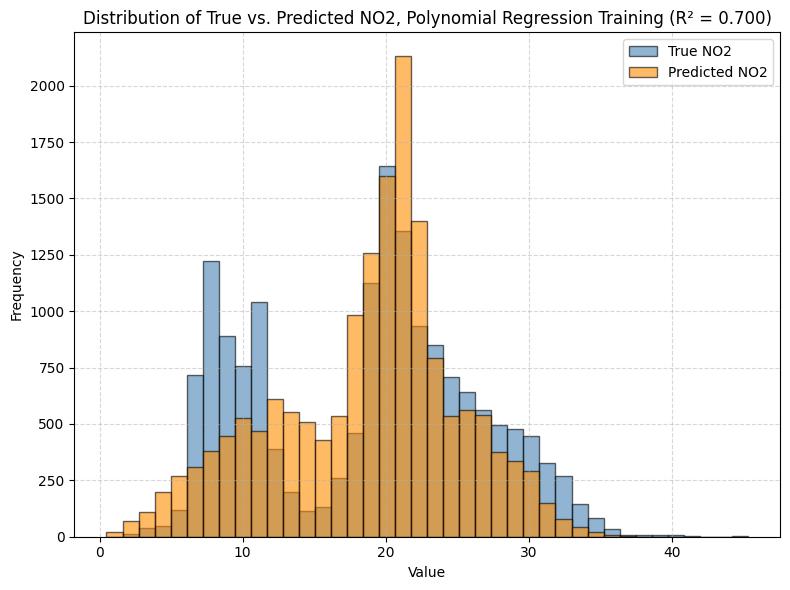

In [184]:
plot_overlaid_histograms(y_true, y_pred,
                         labels=("True NO2", "Predicted NO2"),
                         title="Distribution of True vs. Predicted NO2, Polynomial Regression Training",
                         show_r2=True,
                         bins=40,
                         density=False)

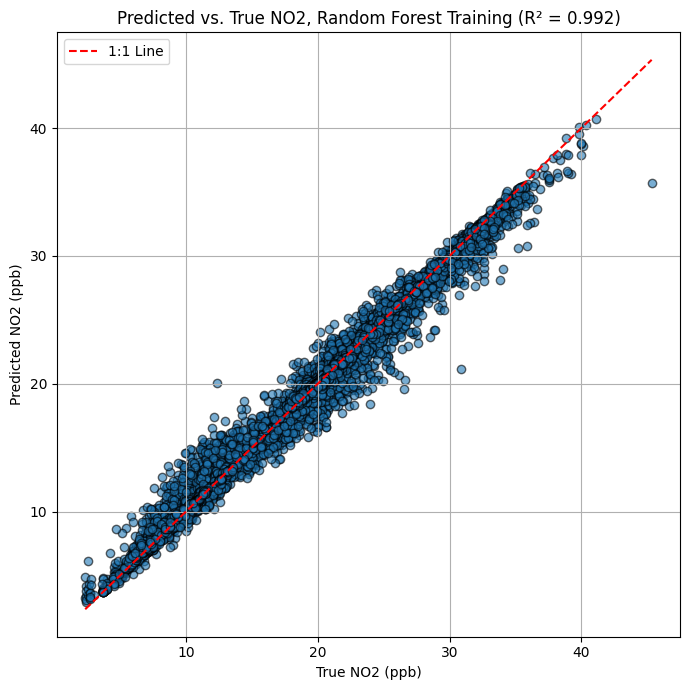

In [185]:
from sklearn.ensemble import RandomForestRegressor
feature_cols = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh"]

#will probably we worth interpolating some data in the future
training_df_clean = training_df.dropna(subset=["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "true_no2"])

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_pred = rf_model.predict(X)

y_true = training_df_clean["true_no2"]

r2 = r2_score(y_true, y_pred)

plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="1:1 Line")
plt.xlabel("True NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f"Predicted vs. True NO2, Random Forest Training (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/var/folders/cv/16s476bd69z2kjqnmm06ls5c0000gn/T/ipykernel_45246/407025799.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data1, data2], labels=labels, patch_artist=True,


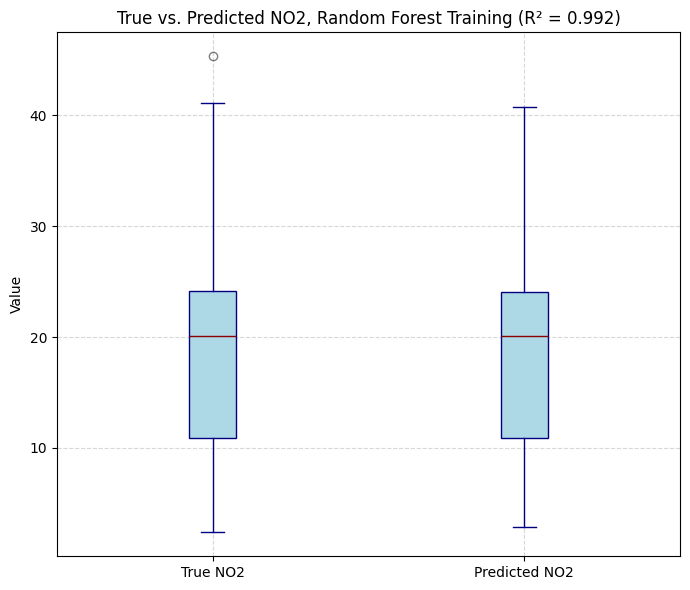

In [186]:
plot_side_by_side_boxes(y_true, y_pred,
                        labels=("True NO2", "Predicted NO2"),
                        title="True vs. Predicted NO2, Random Forest Training",
                        show_r2=True)

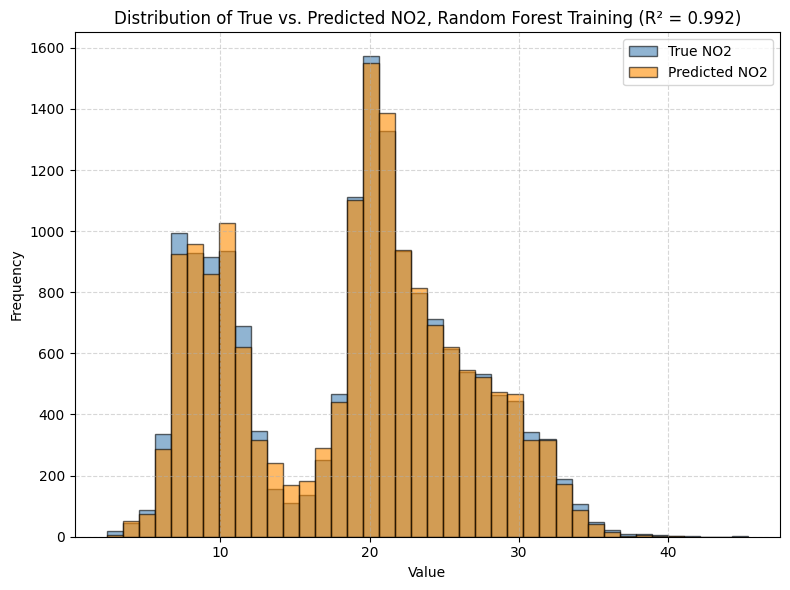

In [187]:
plot_overlaid_histograms(y_true, y_pred,
                         labels=("True NO2", "Predicted NO2"),
                         title="Distribution of True vs. Predicted NO2, Random Forest Training",
                         show_r2=True,
                         bins=40,
                         density=False)

In [188]:
feature_cols = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh"]


# dpw_beacon_df.to_csv("test2.csv")

In [189]:
dpw_df_full = pd.read_csv("data/NO2_DPW_withFlatline.csv")
dpw_df_full.rename(columns={"datetime": "datetime_utc"}, inplace=True)
dpw_df_full["datetime_utc"] = pd.to_datetime(dpw_df_full["datetime_utc"]).dt.floor("min")
columns_to_drop = ["timestamp", "id", "timestamp_local", "sn", "device_state", "pm1_model_id","pm25_model_id","pm10_model_id","co_model_id","no_model_id","no2_model_id","o3_model_id"]
dpw_df_full.drop(columns=columns_to_drop)
new_order = ["datetime_utc", "date_utc", "time_utc", "date_est", "time_est", "rh","temp","lat","lon","pm1","pm25","pm10","co","no","no2","o3", "no2_rolling_std", "flatline_flag"]
dpw_df_full = dpw_df_full[new_order]
dpw_df_full.head()

,datetime_utc,date_utc,time_utc,date_est,time_est,rh,temp,lat,lon,pm1,pm25,pm10,co,no,no2,o3,no2_rolling_std,flatline_flag
0,2025-04-30 23:59:00,2025-04-30,23:59:53,2025-04-30,19:59:53,19.2,21.4,41.79521,-71.39783,2.267,2.606,13.212,731.550,2.188,7.695,54.545,NaN,False
1,2025-04-30 23:58:00,2025-04-30,23:58:53,2025-04-30,19:58:53,19.4,21.5,41.79521,-71.39783,1.927,2.227,2.461,742.599,1.996,7.744,53.284,NaN,False
2,2025-04-30 23:57:00,2025-04-30,23:57:53,2025-04-30,19:57:53,18.7,21.5,41.79521,-71.39783,2.103,2.528,8.526,763.211,2.191,8.391,51.882,NaN,False
3,2025-04-30 23:56:00,2025-04-30,23:56:53,2025-04-30,19:56:53,17.7,21.6,41.79521,-71.39783,0.985,1.174,7.518,773.882,2.259,7.459,53.250,NaN,False
4,2025-04-30 23:55:00,2025-04-30,23:55:53,2025-04-30,19:55:53,17.3,21.6,41.79521,-71.39783,1.385,1.791,3.087,788.944,2.258,7.971,53.545,0.351939,False


In [190]:
testing_df = pd.merge(
    dpw_beacon_df,
    dpw_df_full[["datetime_utc", "no2"]],
    left_on="datetime",
    right_on="datetime_utc"
)
testing_df.rename(columns={"no2": "true_no2"}, inplace=True)
testing_df.head()
testing_df = testing_df.dropna(subset=["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh", "true_no2"])
# testing_df.to_csv("test3.csv")

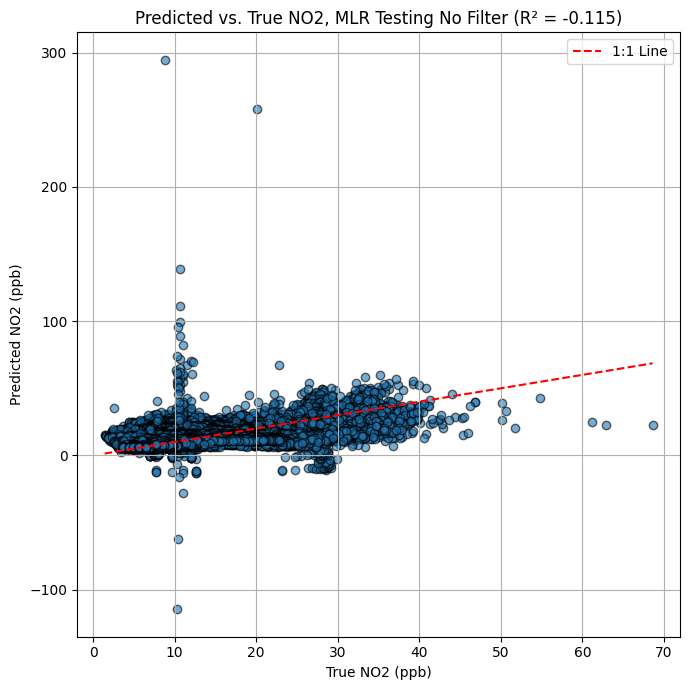

In [191]:
y_true = testing_df["true_no2"]
y_pred = model.predict(testing_df[feature_cols])
feature_cols = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh"]

r2 = r2_score(y_true, y_pred)

plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="1:1 Line")
plt.xlabel("True NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f"Predicted vs. True NO2, MLR Testing No Filter (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/cv/16s476bd69z2kjqnmm06ls5c0000gn/T/ipykernel_45246/407025799.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data1, data2], labels=labels, patch_artist=True,


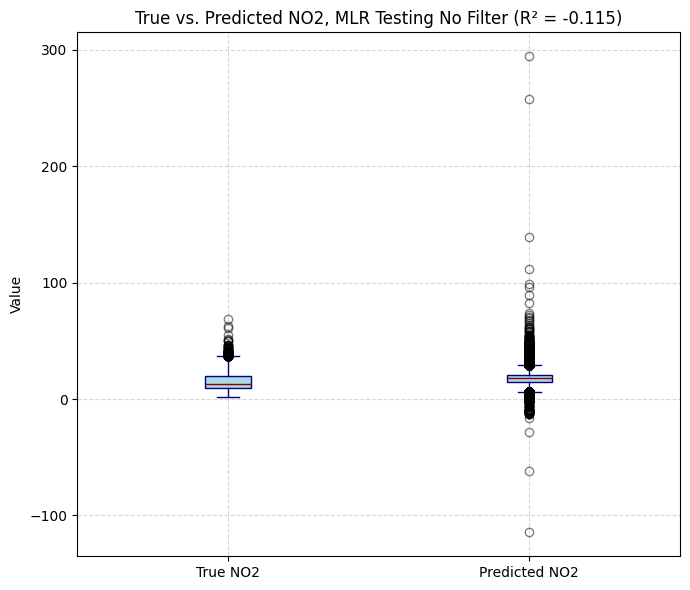

In [192]:
plot_side_by_side_boxes(y_true, y_pred,
                        labels=("True NO2", "Predicted NO2"),
                        title="True vs. Predicted NO2, MLR Testing No Filter",
                        show_r2=True)

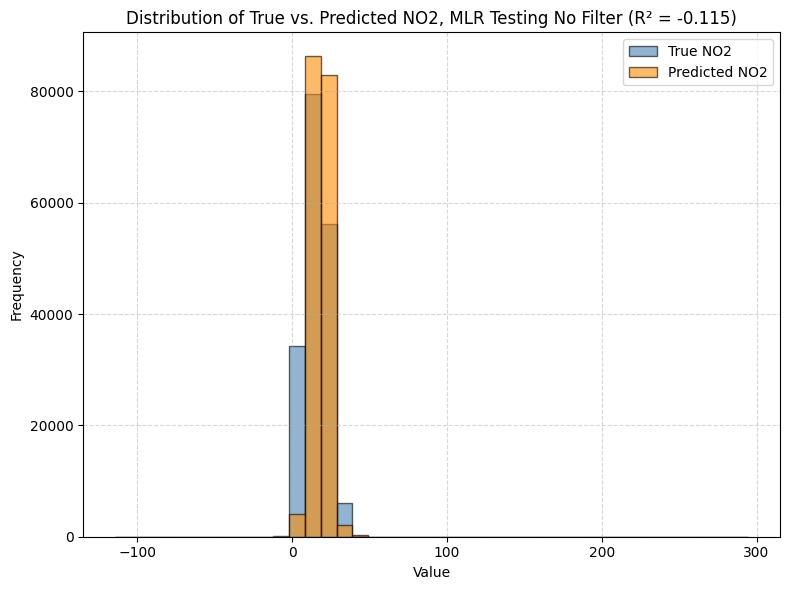

In [193]:
plot_overlaid_histograms(y_true, y_pred,
                         labels=("True NO2", "Predicted NO2"),
                         title="Distribution of True vs. Predicted NO2, MLR Testing No Filter",
                         show_r2=True,
                         bins=40,
                         density=False)

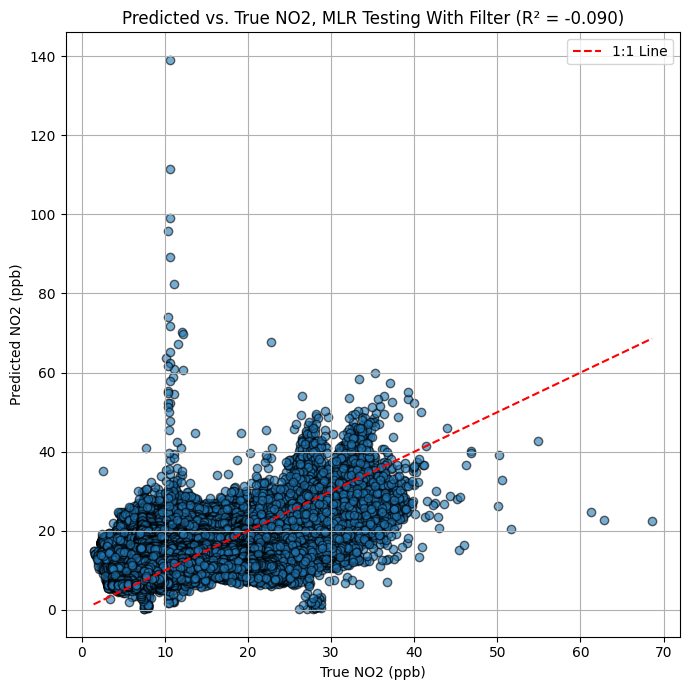

In [194]:
min_val, max_val = 0, 150 

mask = (y_true >= min_val) & (y_true <= max_val) & (y_pred >= min_val) & (y_pred <= max_val)

y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

r2 = r2_score(y_true_filtered, y_pred_filtered)

plt.figure(figsize=(7, 7))
plt.scatter(y_true_filtered, y_pred_filtered, alpha=0.6, edgecolors="k")
plt.plot(
    [y_true_filtered.min(), y_true_filtered.max()],
    [y_true_filtered.min(), y_true_filtered.max()],
    "r--",
    label="1:1 Line"
)
plt.xlabel("True NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f"Predicted vs. True NO2, MLR Testing With Filter (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/cv/16s476bd69z2kjqnmm06ls5c0000gn/T/ipykernel_45246/407025799.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data1, data2], labels=labels, patch_artist=True,


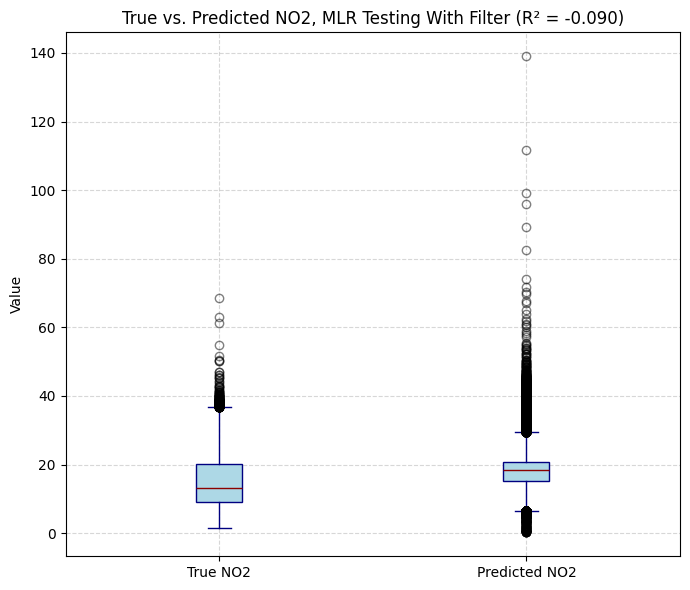

In [195]:
plot_side_by_side_boxes(y_true_filtered, y_pred_filtered,
                        labels=("True NO2", "Predicted NO2"),
                        title="True vs. Predicted NO2, MLR Testing With Filter",
                        show_r2=True)

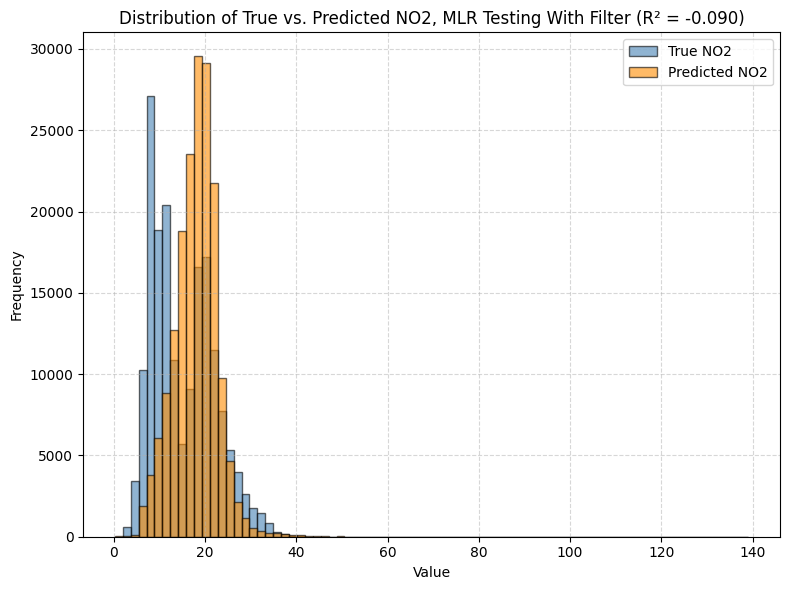

In [196]:
plot_overlaid_histograms(y_true_filtered, y_pred_filtered,
                         labels=("True NO2", "Predicted NO2"),
                         title="Distribution of True vs. Predicted NO2, MLR Testing With Filter",
                         show_r2=True,
                         bins=80,
                         density=False)

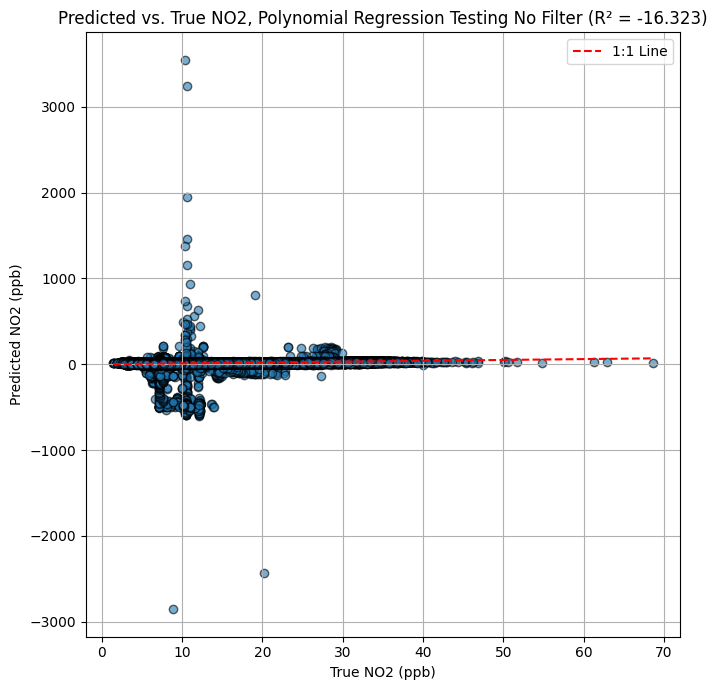

In [197]:
y_true = testing_df["true_no2"]
y_pred = poly_model.predict(testing_df[feature_cols])
feature_cols = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh"]

r2 = r2_score(y_true, y_pred)

plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="1:1 Line")
plt.xlabel("True NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f"Predicted vs. True NO2, Polynomial Regression Testing No Filter (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/cv/16s476bd69z2kjqnmm06ls5c0000gn/T/ipykernel_45246/407025799.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data1, data2], labels=labels, patch_artist=True,


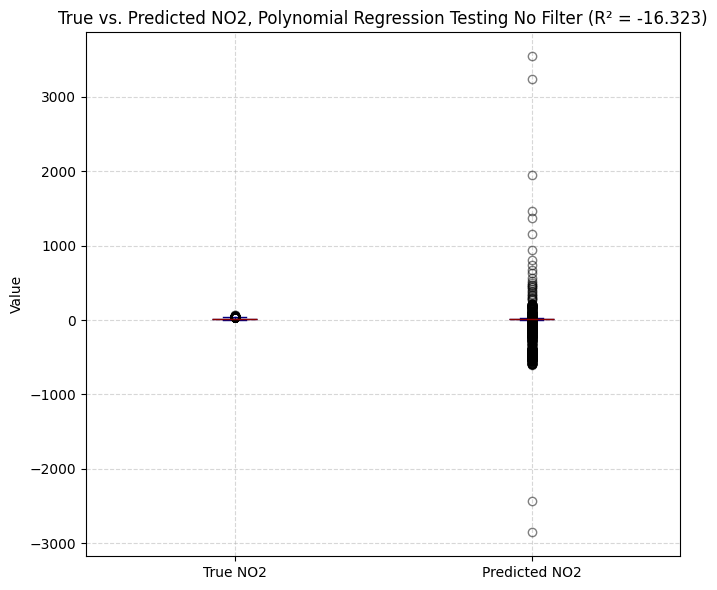

In [198]:
plot_side_by_side_boxes(y_true, y_pred,
                        labels=("True NO2", "Predicted NO2"),
                        title="True vs. Predicted NO2, Polynomial Regression Testing No Filter",
                        show_r2=True)

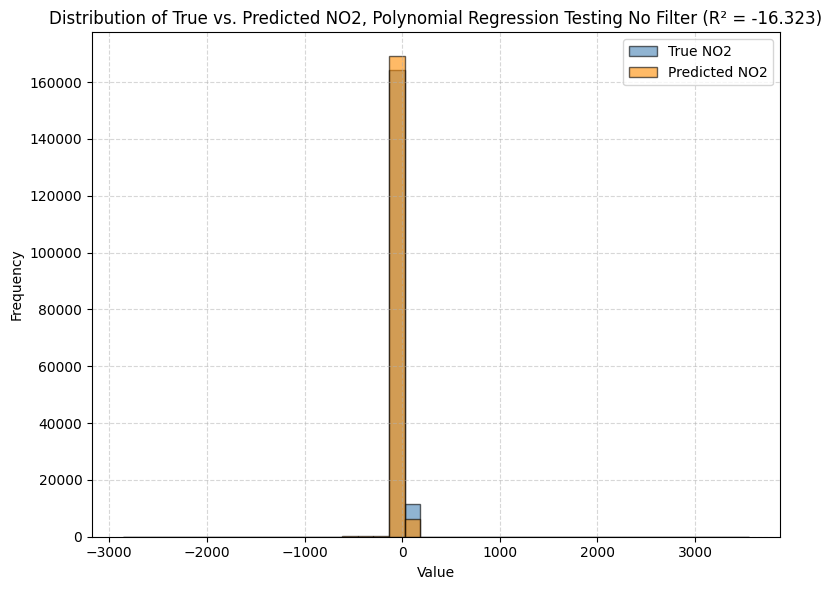

In [199]:
plot_overlaid_histograms(y_true, y_pred,
                         labels=("True NO2", "Predicted NO2"),
                         title="Distribution of True vs. Predicted NO2, Polynomial Regression Testing No Filter",
                         show_r2=True,
                         bins=40,
                         density=False)

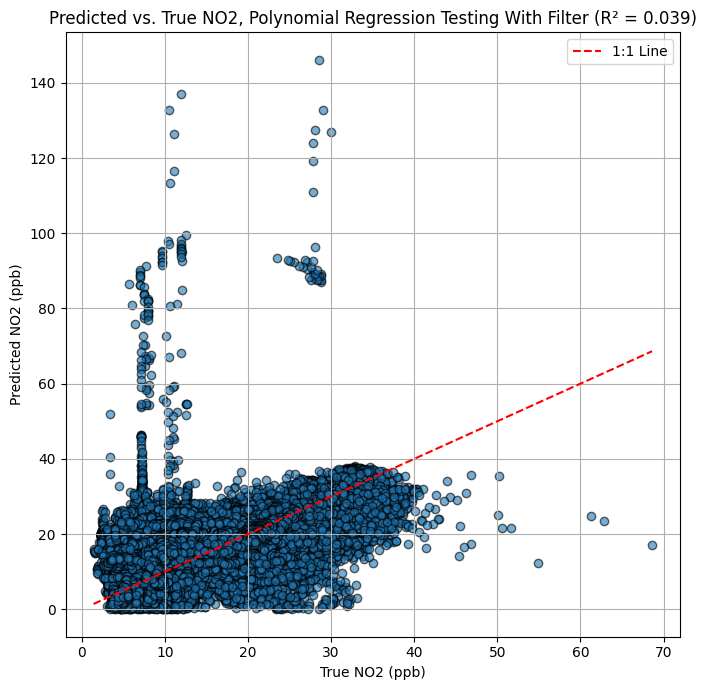

In [200]:
min_val, max_val = 0, 150

mask = (y_true >= min_val) & (y_true <= max_val) & (y_pred >= min_val) & (y_pred <= max_val)

y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

r2 = r2_score(y_true_filtered, y_pred_filtered)

plt.figure(figsize=(7, 7))
plt.scatter(y_true_filtered, y_pred_filtered, alpha=0.6, edgecolors="k")
plt.plot(
    [y_true_filtered.min(), y_true_filtered.max()],
    [y_true_filtered.min(), y_true_filtered.max()],
    "r--",
    label="1:1 Line"
)
plt.xlabel("True NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f"Predicted vs. True NO2, Polynomial Regression Testing With Filter (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/cv/16s476bd69z2kjqnmm06ls5c0000gn/T/ipykernel_45246/407025799.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data1, data2], labels=labels, patch_artist=True,


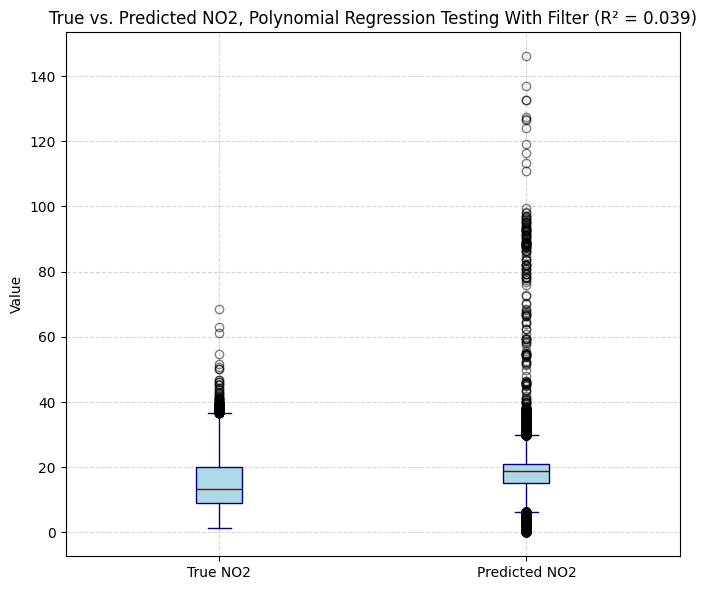

In [201]:
plot_side_by_side_boxes(y_true_filtered, y_pred_filtered,
                        labels=("True NO2", "Predicted NO2"),
                        title="True vs. Predicted NO2, Polynomial Regression Testing With Filter",
                        show_r2=True)

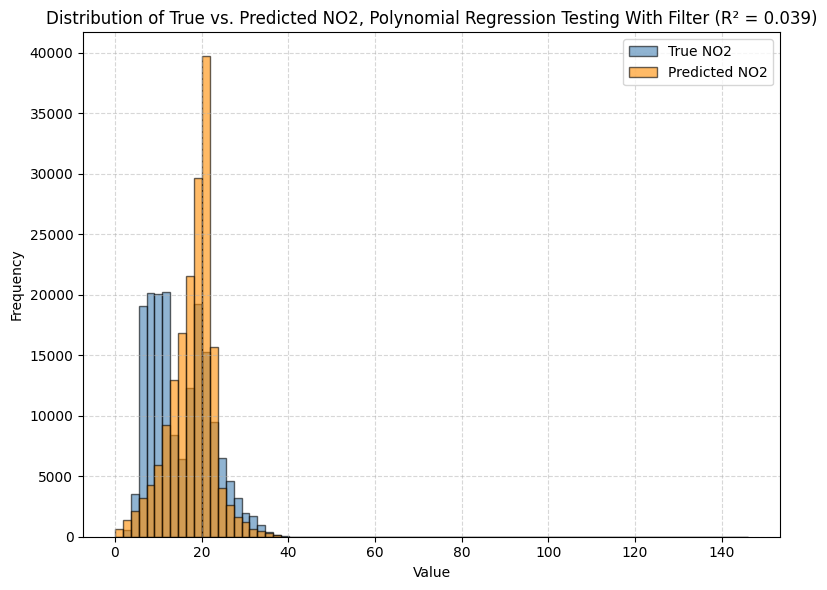

In [202]:
plot_overlaid_histograms(y_true_filtered, y_pred_filtered,
                         labels=("True NO2", "Predicted NO2"),
                         title="Distribution of True vs. Predicted NO2, Polynomial Regression Testing With Filter",
                         show_r2=True,
                         bins=80,
                         density=False)

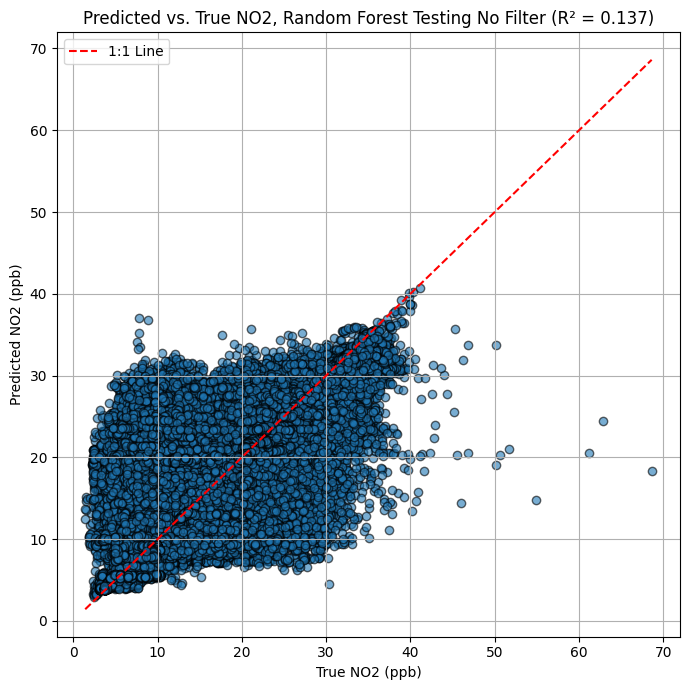

In [203]:
y_true = testing_df["true_no2"]
y_pred = rf_model.predict(testing_df[feature_cols])
feature_cols = ["no2_aux", "o3_wrk_aux", "no_wrk_aux", "temp", "rh"]

r2 = r2_score(y_true, y_pred)

plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.6, edgecolors="k")
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--", label="1:1 Line")
plt.xlabel("True NO2 (ppb)")
plt.ylabel("Predicted NO2 (ppb)")
plt.title(f"Predicted vs. True NO2, Random Forest Testing No Filter (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/cv/16s476bd69z2kjqnmm06ls5c0000gn/T/ipykernel_45246/407025799.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data1, data2], labels=labels, patch_artist=True,


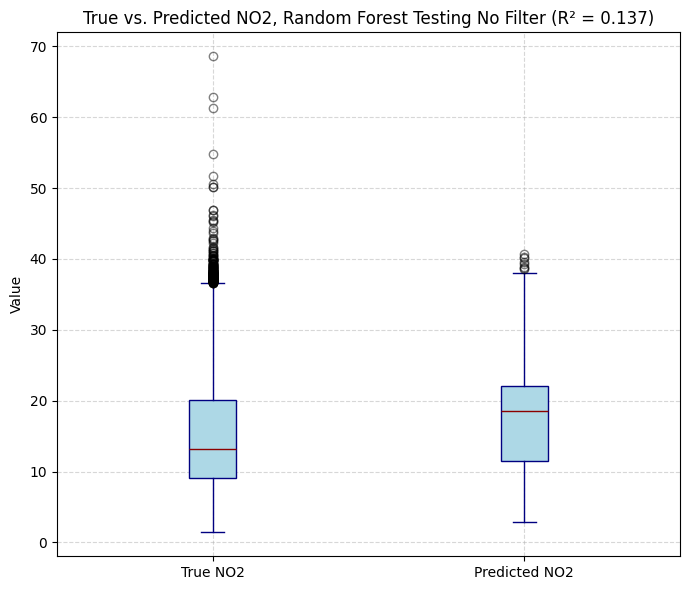

In [204]:
plot_side_by_side_boxes(y_true, y_pred,
                        labels=("True NO2", "Predicted NO2"),
                        title="True vs. Predicted NO2, Random Forest Testing No Filter",
                        show_r2=True)

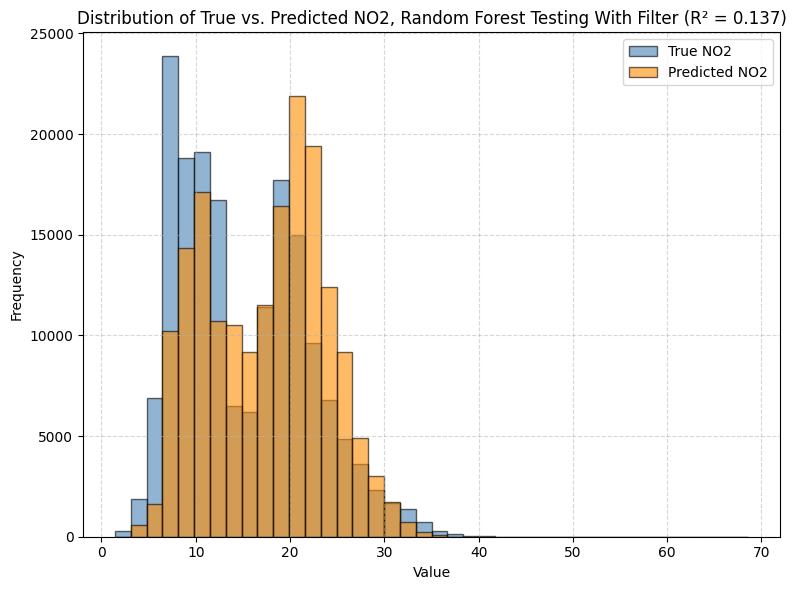

In [205]:
plot_overlaid_histograms(y_true, y_pred,
                         labels=("True NO2", "Predicted NO2"),
                         title="Distribution of True vs. Predicted NO2, Random Forest Testing With Filter",
                         show_r2=True,
                         bins=40,
                         density=False)

In [206]:
def generate_distribution_plots(full_df, filtered_df, site_name):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    filtered_df["hour"] = filtered_df["datetime_utc"].dt.hour

    #no2 boxplots
    axes[0, 0].boxplot(
        [filtered_df["true_no2"].dropna(), full_df["true_no2"].dropna()],
        tick_labels=["Training Data", "All Data"],
        patch_artist=True
    )
    axes[0, 0].set_title("(a) Reference NO₂ Distributions")
    axes[0, 0].set_ylabel("NO₂ (ppb)")

    #temp boxplots
    axes[0, 1].boxplot(
        [filtered_df["temp"].dropna(), full_df["temp"].dropna()],
        tick_labels=["Training Data", "All Data"],
        patch_artist=True
    )
    axes[0, 1].set_title("(b) Temperature Distributions")
    axes[0, 1].set_ylabel("Temperature (°C)")

    #rh boxplots
    axes[1, 0].boxplot(
        [filtered_df["rh"].dropna(), full_df["rh"].dropna()],
        tick_labels=["Training Data", "All Data"],
        patch_artist=True
    )
    axes[1, 0].set_title("(c) RH Distributions")
    axes[1, 0].set_ylabel("RH (%)")

    #hour histogram
    axes[1, 1].hist(filtered_df["hour"], bins=24, edgecolor="black")
    axes[1, 1].set_title("(d) Frequency Distribution of Hours in NO₂ Training Data")
    axes[1, 1].set_xlabel("Hour of Day")
    axes[1, 1].set_ylabel("Frequency")

    plt.suptitle(f"Summary Plots for {site_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

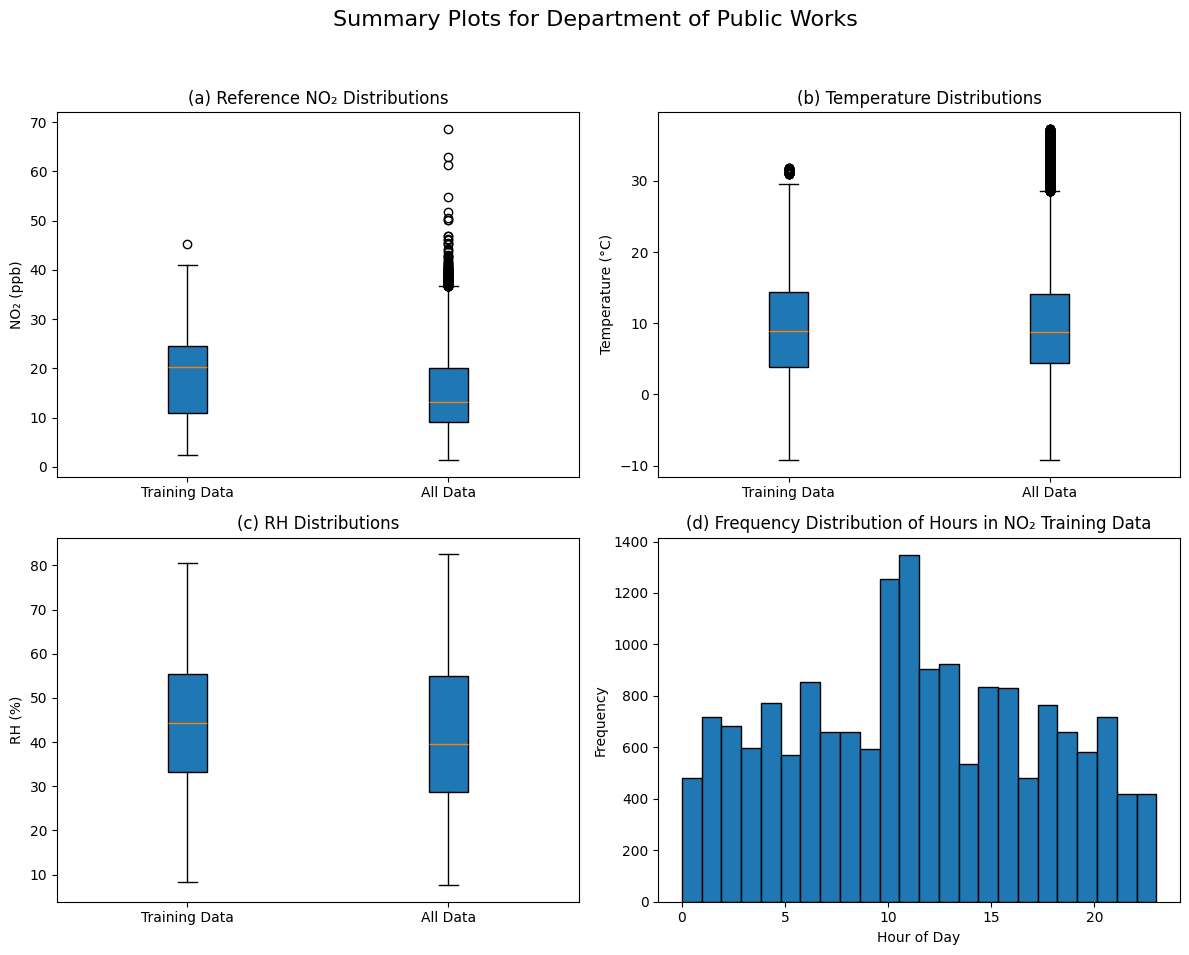

In [207]:
generate_distribution_plots(testing_df, training_df, "Department of Public Works")